In [37]:
import pandas as pd
import numpy  as np
import scipy as sp
import seaborn as sns
import os 
import math
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
import snowflake.connector
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import mannwhitneyu
import csv
url = URL(
    user="ABUHTAREVICH",
    password="",
    account=".gcp",
    warehouse="COMPUTE_WH",
    database="SEVEREX",
    schema="",
    #role='xxxxx',
    #authenticator='https://xxxxx.okta.com',
)
engine = create_engine(url)
connection = engine.connect()

In [53]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm

In [54]:
query = '''
with t1 as(
select adid,
    max(parse_json(publisher_parameters):test_name::string) over(partition by adid) as test_name,
    max(parse_json(publisher_parameters):group_name::string) over(partition by adid) as group_name,
    datediff(day, date(installed_at), date(created_at)) as day,
    iff(event_name is NULL, activity_kind, event_name) as event_name1,
    country,
    network_name
from "SEVEREX"."ADJUST"."EVENTS"
where app_id = 'com.europosit.polygon2d.coloringpuzzle'
    and date(installed_at) between '2022-11-04' and '2022-11-22'
    and day <= 2
)
select adid,
       country,
       group_name,
       count(iff(event_name1 = 'app_game_started', 1, 0)) as game_started,
       count(iff(event_name1 = 'app_game_ended',1, 0)) as game_ended,
       count(iff(event_name1 = 'ads_banner_impression',1, 0)) as banners,
       count(iff(event_name1 = 'ads_interstitial_impression',1, 0)) as inters,
       count(iff(event_name1 = 'ads_rewarded_impression', 1, 0)) as rewards
from t1
where test_name = 'ab_inter_while_gaming'
and group_name in ('ab_inter_while_gaming_old', 'ab_inter_while_gaming_old_copy')
//and country = 'us'
group by 1,2,3

'''
df_rev = pd.read_sql(query, connection)


In [55]:
df_rev

,adid,country,group_name,game_started,game_ended,banners,inters,rewards
0,f3db5d3c726e92792e7724fe0ce7e046,br,ab_inter_while_gaming_old,59,59,59,59,59
1,87a69c19988ac67876079d95f07383a6,it,ab_inter_while_gaming_old,50,50,50,50,50
2,8bc550089ffabf4f84e3abfe06eb296c,vn,ab_inter_while_gaming_old_copy,87,87,87,87,87
3,fae17449495289edb0a89a474c46e919,us,ab_inter_while_gaming_old,761,761,761,761,761
4,3624fef73a26ea08d8f5c6d58d40ed42,pl,ab_inter_while_gaming_old_copy,127,127,127,127,127
...,...,...,...,...,...,...,...,...
6593,13501c12c82376fe2138f628161768ea,ru,ab_inter_while_gaming_old,119,119,119,119,119
6594,8c7c6dde0432b912265ce590bb6122e4,us,ab_inter_while_gaming_old,29,29,29,29,29
6595,1fa1dd4101c38c3c7a2a6880e7edb790,gb,ab_inter_while_gaming_old_copy,16,16,16,16,16
6596,b1bc51b8b53fe4a9489b183dbef891b2,ca,ab_inter_while_gaming_old,44,44,44,44,44


In [56]:
df_ID=df_rev

In [57]:
df_ID

,adid,country,group_name,game_started,game_ended,banners,inters,rewards
0,f3db5d3c726e92792e7724fe0ce7e046,br,ab_inter_while_gaming_old,59,59,59,59,59
1,87a69c19988ac67876079d95f07383a6,it,ab_inter_while_gaming_old,50,50,50,50,50
2,8bc550089ffabf4f84e3abfe06eb296c,vn,ab_inter_while_gaming_old_copy,87,87,87,87,87
3,fae17449495289edb0a89a474c46e919,us,ab_inter_while_gaming_old,761,761,761,761,761
4,3624fef73a26ea08d8f5c6d58d40ed42,pl,ab_inter_while_gaming_old_copy,127,127,127,127,127
...,...,...,...,...,...,...,...,...
6593,13501c12c82376fe2138f628161768ea,ru,ab_inter_while_gaming_old,119,119,119,119,119
6594,8c7c6dde0432b912265ce590bb6122e4,us,ab_inter_while_gaming_old,29,29,29,29,29
6595,1fa1dd4101c38c3c7a2a6880e7edb790,gb,ab_inter_while_gaming_old_copy,16,16,16,16,16
6596,b1bc51b8b53fe4a9489b183dbef891b2,ca,ab_inter_while_gaming_old,44,44,44,44,44


In [58]:
df_ID_test_1=df_ID.groupby(['adid','group_name','country']).max().reset_index()

In [59]:
baseline =df_ID_test_1.query("group_name=='ab_inter_while_gaming_old'")
copy_baseline =df_ID_test_1.query("group_name=='ab_inter_while_gaming_old_copy'")

  0%|          | 0/10000 [00:00<?, ?it/s]

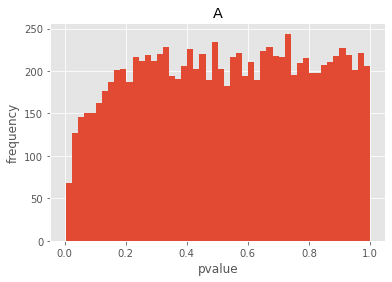

0.026

In [63]:
n = 1500 #Размер выборки
simulations=10000 #Количество симуляций 
n_s = 1500 # Количество наблюдений в подвыборке
res=[]

#df=pd.DataFrame({
#    's1':np.random.exponential(scale=1/0.001, size=n),
#    's2':np.random.exponential(scale=1/0.001, size=n)
#})

for i in tqdm(range(simulations)):
    s1=baseline.banners.sample(n=n_s, replace=False)
    s2=copy_baseline.banners.sample(n=n_s, replace=False)
    res.append(stats.ttest_ind(s1, s2, axis=0, equal_var=True)[1])

plt.hist(res,bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalue')
plt.ylabel('frequency')
plt.title('A')
plt.show()
  
sum(np.array(res)<0.05)/simulations   
    
    
   

In [49]:
sum(np.array(res)<0.1)/simulations   

0.0446

In [50]:
sum(np.array(res)<0.02)/simulations   

0.001

In [35]:
sum(np.array(res)<0.9)/simulations   

1.0

In [281]:
df_ID_test

,adid,groups,country,cohort_day,inter_rev,banner_rev,reward_rev,purchase_rev,all_arpu
0,0005b87ae25726be319455114c937ff8,old_vault,ph,1,0.04111,0.02201,0.00000,0.0,0.06312
1,0007cd5f8c9a1f6bf4222e227f97b7fc,new_vault,ph,6,0.00000,0.00000,0.00000,0.0,0.00000
2,00088565ac4e8cb5710faa713141dbe1,new_vault,ph,1,0.01315,0.01485,0.04791,0.0,0.07591
3,000c4adcb9f2f89335af079d76b60fd8,old_vault,ph,2,0.00583,0.01614,0.03698,0.0,0.05895
4,000e1e66ba173534253de45f548260c8,new_vault,ph,2,0.02294,0.00718,0.00000,0.0,0.03012
...,...,...,...,...,...,...,...,...,...
25793,ffeb3d8be1859f4805b187e7032f20e5,old_vault,ph,6,0.04119,0.01681,0.10134,0.0,0.15934
25794,fff3df1365981c87765e60e342ec7701,old_vault,ph,0,0.05629,0.01569,0.05889,0.0,0.13087
25795,fff4135c369dee9d010c935385f325ca,old_vault,ph,3,0.00475,0.01153,0.01772,0.0,0.03400
25796,fff7b5e58d2ecc60ec031c551ce6c7fb,old_vault,ph,0,0.06130,0.03462,0.11362,0.0,0.20954


In [282]:
list_res=[]
group_tgs=["new_vault"]
for group_tg in group_tgs:
    tg=df_ID_test.query('groups==@group_tg').all_arpu
    cg=df_ID_test.query("groups=='old_vault'").all_arpu
    mann_whitney_two=mannwhitneyu(tg,cg,alternative='two-sided')
    print('country','ph','; TG group:',group_tg,'; p_value',mann_whitney_two[1],';  TG mean',tg.mean(), ';  CG mean',cg.mean(), '; TG larger than CG', tg.mean()/cg.mean())
    dict_a={'country':'ph','TG group':group_tg,'p_value':mann_whitney_two[1],'TG mean':tg.mean(),'CG mean':cg.mean(),'TG larger than CG,mean':tg.mean()/cg.mean(),
           'TG median':tg.median(),'CG median':cg.median(),'TG larger than CG,median':tg.median()/cg.median()}
    list_res.append(dict_a)

country ph ; TG group: new_vault ; p_value 0.9210246149814042 ;  TG mean 0.13482866754311434 ;  CG mean 0.1283360775627578 ; TG larger than CG 1.050590528428622


In [283]:
pd.DataFrame(list_res)

,country,TG group,p_value,TG mean,CG mean,"TG larger than CG,mean",TG median,CG median,"TG larger than CG,median"
0,ph,new_vault,0.921025,0.134829,0.128336,1.050591,0.0668,0.0675,0.98963


In [252]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import random

In [253]:
tg=random.choices(df_ID_test.adid, k=10000)

In [254]:
df_ID_test.adid

0        0005b87ae25726be319455114c937ff8
1        0007cd5f8c9a1f6bf4222e227f97b7fc
2        00088565ac4e8cb5710faa713141dbe1
3        000c4adcb9f2f89335af079d76b60fd8
4        000e1e66ba173534253de45f548260c8
                       ...               
25793    ffeb3d8be1859f4805b187e7032f20e5
25794    fff3df1365981c87765e60e342ec7701
25795    fff4135c369dee9d010c935385f325ca
25796    fff7b5e58d2ecc60ec031c551ce6c7fb
25797    fff80f8aa3db6861ebe147c87e80962b
Name: adid, Length: 25798, dtype: object

In [295]:
# уровень значимости с поправкой бонферони 0.975

def bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статисбутстраптика
    bootstrap_conf_level = 0.05# уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in (range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values 
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        boot_data.append(statistic([samples_1 - samples_2])) # применяем статистику

        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('mean')
    plt.ylabel('frequency')
    plt.title("Распределение разниц между бутстрапированными группами по среднему")
    # plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [285]:
tg_b=df_ID_test.query("groups=='new_vault'")
cg_b=df_ID_test.query("groups=='old_vault'")

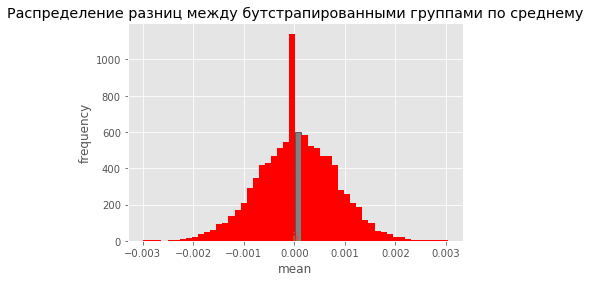

In [286]:
a_test = bootstrap(tg_b.all_arpu,cg_b.all_arpu,statistic=np.median)

In [287]:
# Значение p-value

a_test['p_value']

0.9895350298060109

In [288]:
a_test['quants']

,0
0.475,0.00000
0.525,0.00006


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

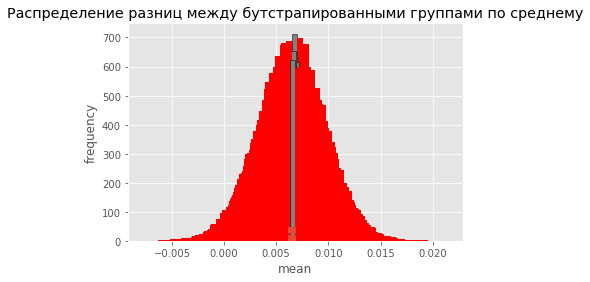

In [289]:

list_with_results=[]
for i in tqdm(range (100)):
    a_test = bootstrap(tg_b.all_arpu,cg_b.all_arpu)
    list_with_results.append(a_test['p_value'])

In [ ]:
result_df=pd.DataFrame(list_with_results)

In [ ]:
result_df.describe(percentiles=[0.93])

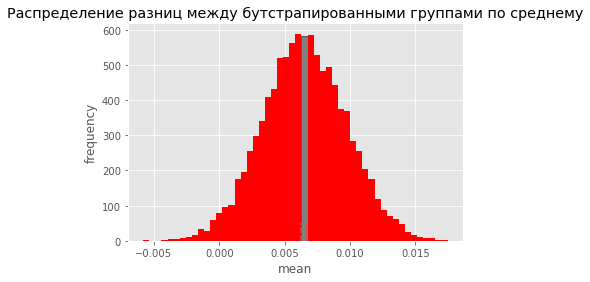

In [290]:
a_test = bootstrap(tg_b.all_arpu,cg_b.all_arpu)

In [291]:
# Значение p-value

a_test['p_value']

0.04260765716261272

In [292]:
a_test['quants']

,0
0.475,0.006277
0.525,0.006676


In [293]:
test_for_bootstrap_tg_50_perc=df_ID_test.query("groups=='new_vault'").all_arpu.quantile(q=0.5)
test_for_bootstrap_tg=df_ID_test.query("groups=='new_vault'&all_arpu<=@test_for_bootstrap_tg_50_perc").reset_index()
test_for_bootstrap_cg_50_perc=df_ID_test.query("groups=='old_vault'").all_arpu.quantile(q=0.5)
test_for_bootstrap_cg=df_ID_test.query("groups=='old_vault'&all_arpu<=@test_for_bootstrap_cg_50_perc").reset_index()

In [296]:
list_with_diff=[]
for i in range (1000):
    tg_pol=random.choices(test_for_bootstrap_tg.all_arpu, k=10000)#np.mean()
    cg_pol=np.mean(random.choices(test_for_bootstrap_cg.all_arpu, k=10000))
    difference=tg_pol-cg_pol
    list_with_diff.append(difference)
    

In [297]:
pd.DataFrame(list_with_diff).plot(kind='hist', density = False, bins=100, figsize=(16,6))
# plt.title('Распределение пользователей по победам')
# plt.xlabel('Кол-во побед')
# plt.ylabel('Плотность')

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/severex_da_12_21/opt/anaconda3/lib/python3.9/site-packages/snowflake/connector/network.py", line 719, in _post_request
    ret = self._renew_session()
  File "/Users/severex_da_12_21/opt/anaconda3/lib/python3.9/site-packages/snowflake/connector/network.py", line 492, in _renew_session
    return self._token_request(REQUEST_TYPE_RENEW)
  File "/Users/severex_da_12_21/opt/anaconda3/lib/python3.9/site-packages/snowflake/connector/network.py", line 548, in _token_request
    raise ReauthenticationRequest(
snowflake.connector.network.ReauthenticationRequest: 390114 (08001): Authentication token has expired.  The user must authenticate again.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/severex_da_12_21/opt/anaconda3/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 682, in _finalize_fairy
    fairy._reset(pool)
  File "/Users

<AxesSubplot:ylabel='Frequency'>

Error in callback <function flush_figures at 0x7fd187a07550> (for post_execute):


KeyboardInterrupt: 

In [ ]:
bs.bootstrap(np.array(list_with_diff), stat_func=bs_stats.mean)

In [ ]:
pd.options.display.float_format = '{:.8f}'.format
pd.DataFrame(list_with_diff).describe(percentiles=[0.025,0.975])